# Multi-Model Evaluation for Movie Genre Prediction

This notebook demonstrates how to use the ModelEvaluator class to evaluate multiple machine learning models from basic to advanced for predicting movie genres based on plot descriptions.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import hstack, csr_matrix

# Import our custom ModelEvaluator class
from model_evaluator import ModelEvaluator

## 1. Load and Prepare the Data

In [2]:
# Load the preprocessed data
df = pd.read_csv('wiki_movie_plots_deduped_cleaned.csv')
print(f"Loaded dataset with {len(df)} movies")
print(df.columns.tolist())

Loaded dataset with 34886 movies
['Unnamed: 0', 'Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot', 'genres_list', 'Genre_list', 'Cast_list', 'genre_list_raw', 'genre_list', 'plot_clean', 'plot_lemmatized']


In [ ]:
# Check the first few rows
df.head()

In [ ]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

In [9]:
df['genre_list'].unique()

array(['[]', "['western']", "['comedy']", "['crime', 'action']",
       "['drama']", "['adventure']", "['fantasy']", "['sport']",
       "['horror']", "['crime']", "['drama', 'horror']",
       "['documentary']", "['western', 'comedy']", "['biography']",
       "['action']", "['mystery']", "['romance']",
       "['drama', 'adventure']", "['fantasy', 'family']", "['war']",
       "['comedy', 'adventure']", "['fantasy', 'adventure']",
       "['thriller']", "['drama', 'comedy']", "['thriller', 'mystery']",
       "['romance', 'fantasy']", "['mystery', 'horror', 'comedy']",
       "['romance', 'drama']", "['romance', 'comedy']",
       "['crime', 'drama']", "['musical']", "['drama', 'war']",
       "['horror', 'comedy']", "['musical', 'comedy']",
       "['drama', 'western']", "['drama', 'thriller']",
       "['sci-fi', 'horror']", "['crime', 'mystery']",
       "['musical', 'drama']", "['drama', 'mystery']", "['animation']",
       "['sci-fi']", "['crime', 'comedy']", "['drama', 'sport']

In [16]:
df = df[df['genre_list']!="[]"]

## 2. Feature Engineering

In [17]:
# Create TF-IDF features from plot descriptions
tfidf = TfidfVectorizer(
    max_features=5000,         # limit features for performance
    stop_words='english',      # remove common English stopwords
    ngram_range=(1, 2),        # unigrams and bigrams
    min_df=5,                  # ignore terms that appear in <5 documents
    max_df=0.8,                # ignore very frequent terms
    strip_accents='unicode',   # normalize accents
    sublinear_tf=True          # apply sublinear tf scaling
)

# Transform the plot_lemmatized column
X_plot = tfidf.fit_transform(df['plot_lemmatized'])
print(f"TF-IDF features shape: {X_plot.shape}")

TF-IDF features shape: (26808, 5000)


In [18]:
# Prepare the target variable (genre)
# Convert genre lists to binary format
mlb_genre = MultiLabelBinarizer()
y = mlb_genre.fit_transform(df['genre_list'])
print(f"Target shape: {y.shape}")
print(f"Genre classes: {mlb_genre.classes_}")

Target shape: (26808, 27)
Genre classes: [' ' "'" ',' '-' '[' ']' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'l' 'm' 'n'
 'o' 'p' 'r' 's' 't' 'u' 'v' 'w' 'y']


array([[0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1]])

In [20]:
# Add location features
X_location = pd.get_dummies(df['Origin/Ethnicity'], prefix='loc')
print(f"Location features shape: {X_location.shape}")

Location features shape: (26808, 24)


In [21]:
# Combine all features
X_combined = hstack([X_plot, csr_matrix(X_location.values)])
print(f"Combined features shape: {X_combined.shape}")

Combined features shape: (26808, 5024)


## 3. Feature Selection

In [22]:
# Select top features based on chi-squared scores
k = 2000  # Number of top features to select
selector = SelectKBest(chi2, k=k)
X_selected = selector.fit_transform(X_combined, y)
print(f"Selected features shape: {X_selected.shape}")

Selected features shape: (26808, 2000)


## 4. Initialize the ModelEvaluator

In [23]:
# Create an instance of ModelEvaluator
evaluator = ModelEvaluator(random_state=42)

In [24]:
# Add basic models
evaluator.add_basic_models()

In [25]:
# Add intermediate models
evaluator.add_intermediate_models()

In [26]:
# Add advanced models
evaluator.add_advanced_models()

## 5. Evaluate All Models

In [27]:
# Get feature names (for feature importance plots)
# Combine TF-IDF feature names and location feature names
tfidf_feature_names = tfidf.get_feature_names_out()
location_feature_names = X_location.columns.tolist()
all_feature_names = list(tfidf_feature_names) + location_feature_names

# Get selected feature names
selected_indices = selector.get_support(indices=True)
selected_feature_names = [all_feature_names[i] for i in selected_indices]

In [28]:
# Evaluate all models
evaluator.evaluate_models(
    X=X_selected, 
    y=y, 
    test_size=0.2, 
    feature_names=selected_feature_names,
    target_names=mlb_genre.classes_
)

Evaluation complete. Best model: Neural Network MLP (F1-micro: 0.8003)


## 6. Analyze Results

In [29]:
# Print summary of all models
summary = evaluator.print_summary()

Model Performance Summary:
                     Model  F1-micro  F1-macro  F1-weighted  Hamming Loss
0       Neural Network MLP  0.800267  0.540225     0.779576      0.130051
1      Logistic Regression  0.797996  0.498653     0.768947      0.130638
2               Linear SVM  0.795979  0.531052     0.774222      0.133028
3                 LightGBM  0.793823  0.509611     0.766226      0.133815
4                  XGBoost  0.785183  0.511806     0.760346      0.140122
5            Random Forest  0.779070  0.433729     0.734787      0.140895
6  Multinomial Naive Bayes  0.777485  0.467397     0.743205      0.143272
7        Gradient Boosting  0.773327  0.460794     0.732920      0.146470
8            Decision Tree  0.709461  0.467272     0.708556      0.197273


## 7. Save Models to Disk

In [37]:
# Import the ModelSaver class
from model_saver import ModelSaver

In [38]:
# Create a ModelSaver instance
saver = ModelSaver(base_dir='saved_models')

In [39]:
# Save all models
save_info = saver.save_all_models(
    evaluator=evaluator,
    dataset_name='movie_genre_prediction',
    include_data=False  # Set to True if you want to save the dataset as well
)

Model Performance Summary:
                     Model  F1-micro  F1-macro  F1-weighted  Hamming Loss
0       Neural Network MLP  0.800267  0.540225     0.779576      0.130051
1      Logistic Regression  0.797996  0.498653     0.768947      0.130638
2               Linear SVM  0.795979  0.531052     0.774222      0.133028
3                 LightGBM  0.793823  0.509611     0.766226      0.133815
4                  XGBoost  0.785183  0.511806     0.760346      0.140122
5            Random Forest  0.779070  0.433729     0.734787      0.140895
6  Multinomial Naive Bayes  0.777485  0.467397     0.743205      0.143272
7        Gradient Boosting  0.773327  0.460794     0.732920      0.146470
8            Decision Tree  0.709461  0.467272     0.708556      0.197273
All models saved successfully to saved_models\movie_genre_prediction_20250520_224334


In [40]:
# Alternatively, save only the best model
best_model_info = saver.save_best_model(
    evaluator=evaluator,
    dataset_name='movie_genre_prediction'
)

Best model (Neural Network MLP) saved successfully to saved_models\movie_genre_prediction_best_20250520_225444


## 8. Load and Use Saved Models

### 8.1 Loading a Single Model

In [ ]:
# Example of loading a saved model
# Replace with the actual path from the save_info output
model_path = save_info['models']['Neural Network MLP']['model_path']
loaded_model = saver.load_model(model_path)

# Now you can use the loaded model for predictions
# Example:
# new_data = ...
# predictions = loaded_model.predict(new_data)

### 8.2 Loading All Models into a ModelEvaluator

In [ ]:
# Find all saved model directories

saved_dirs = saver.find_saved_models()
print(f"Found {len(saved_dirs)} saved model directories:")
for i, info in enumerate(saved_dirs):
    model_type = "Best model only" if info['is_best_only'] else f"{info['model_count']} models"
    print(f"{i+1}. {info['name']} ({model_type}) - {info['timestamp']}")

In [52]:
del saver

In [54]:
from model_saver import ModelSaver
saver = ModelSaver(base_dir='saved_models')

In [ ]:
# Load models from the directory we just created

save_dir = save_info['base_directory']
loaded_evaluator = saver.load_models_into_evaluator(save_dir)

# Print summary of loaded models
loaded_summary = loaded_evaluator.print_summary()

In [ ]:
# Compare the original and loaded evaluator summaries
print("Original evaluator summary:")
print(summary)
print("\nLoaded evaluator summary:")
print(loaded_summary)

In [ ]:
# Visualize the loaded models' performance
loaded_evaluator.plot_model_comparison()

In [ ]:
# Get the best model from the loaded evaluator
best_model = loaded_evaluator.best_model
print(f"Best model: {loaded_evaluator.best_model_name}")
print(f"Best score: {loaded_evaluator.best_score:.4f}")

# You can now use this model for predictions
# Example:
# predictions = best_model.predict(new_data)

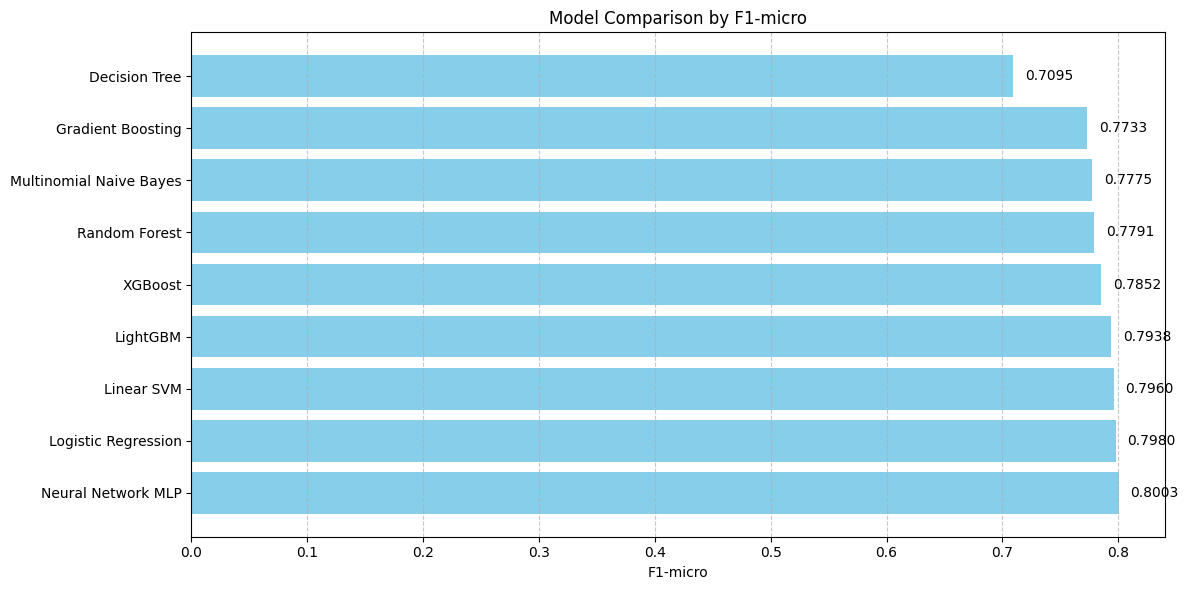

In [30]:
# Plot model comparison by F1-micro score
evaluator.plot_model_comparison(metric='f1_micro')

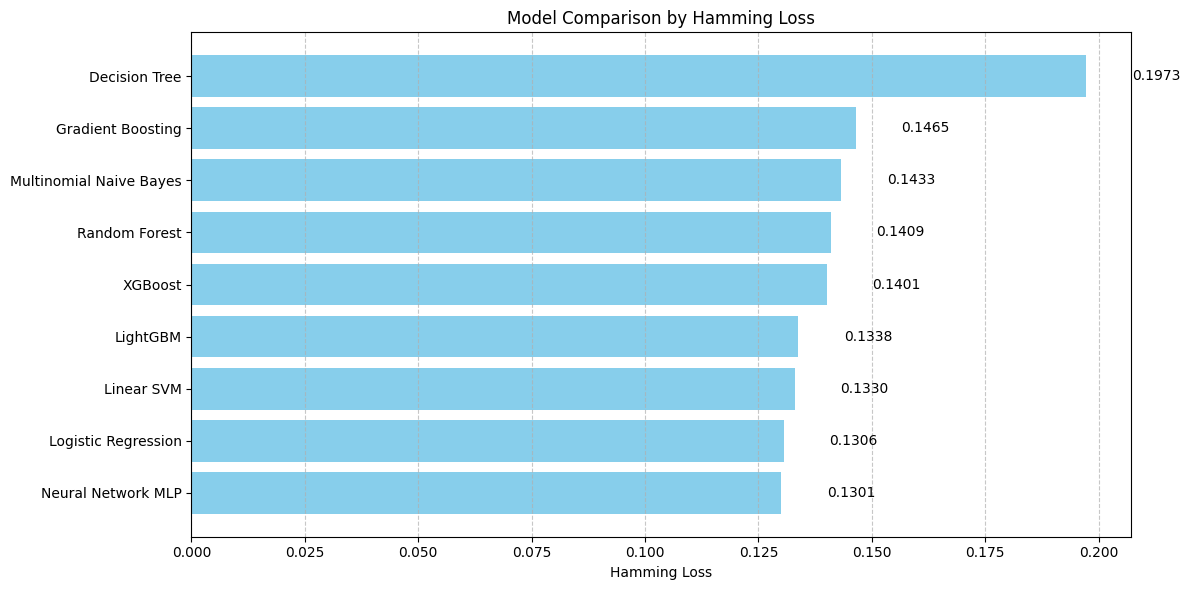

In [31]:
# Plot model comparison by Hamming Loss (lower is better)
evaluator.plot_model_comparison(metric='hamming_loss')

Too many classes (27) for confusion matrices. Showing only for the first 10 classes.


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

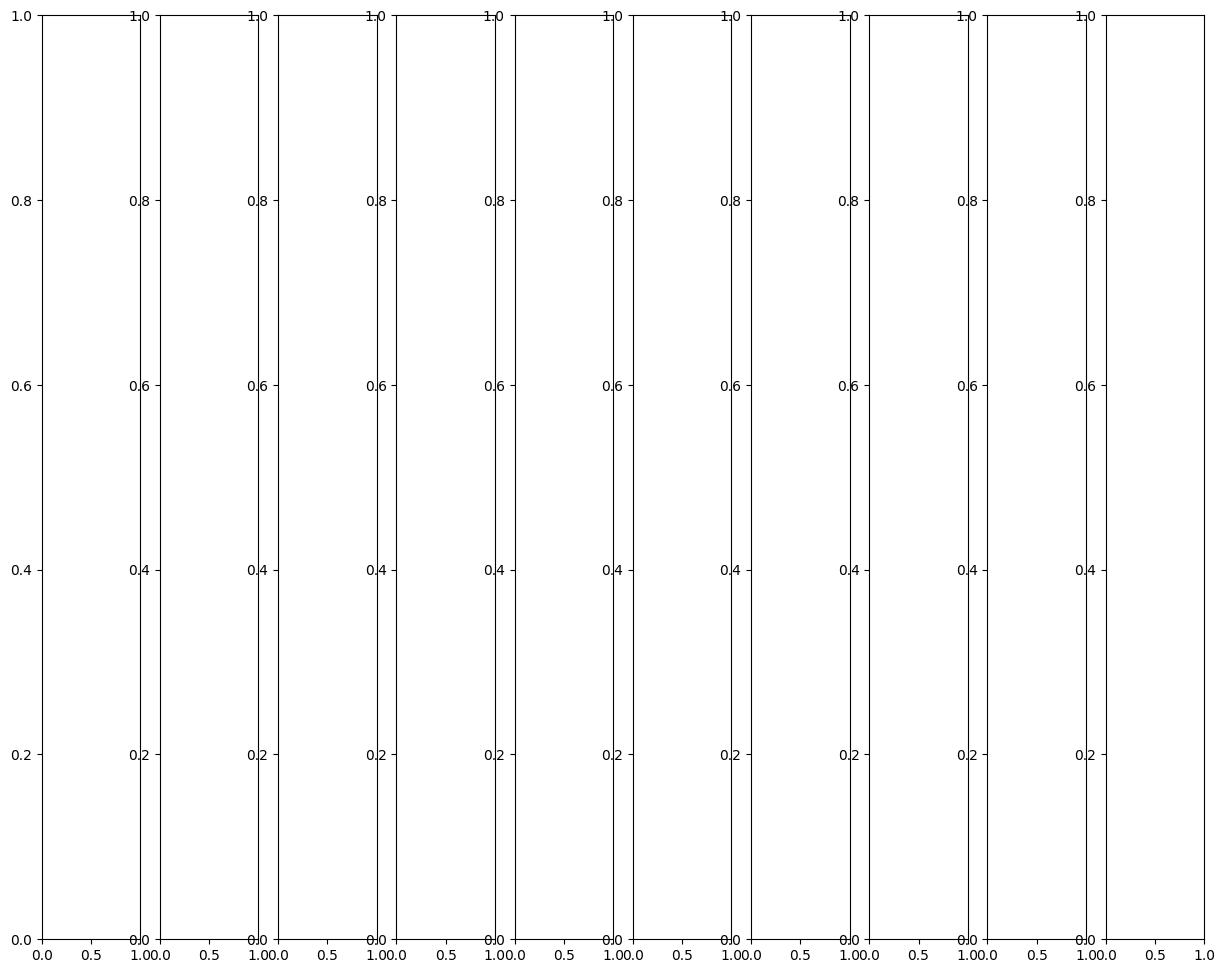

In [32]:
# Plot confusion matrices for the best model
evaluator.plot_confusion_matrices()

Too many classes (27) for confusion matrices. Showing only for the first 10 classes.


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

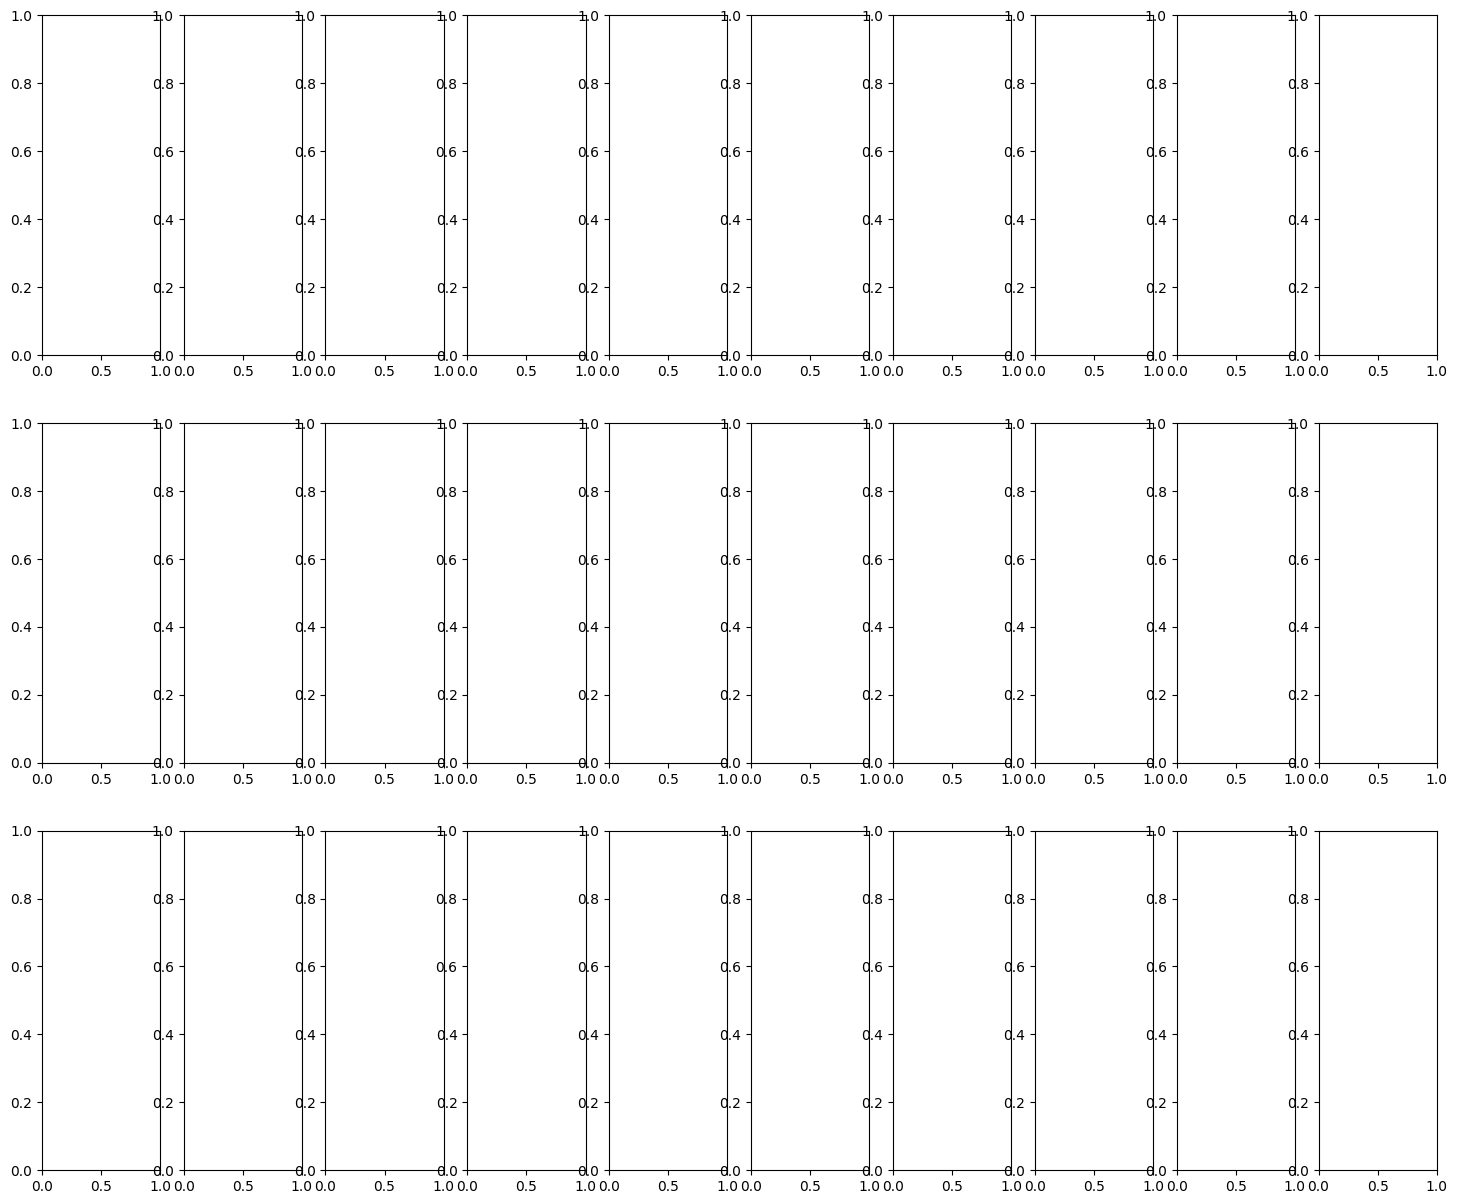

In [33]:
# Compare top 3 models with confusion matrices
top_models = summary['Model'].head(3).tolist()
evaluator.plot_confusion_matrices(model_names=top_models, figsize=(18, 15))

## 7. Feature Importance Analysis

In [34]:
# Plot feature importance for the best model
evaluator.plot_feature_importance(top_n=20)

Model Neural Network MLP doesn't provide feature importance.


In [41]:
# Get feature importance for a specific model
if 'Random Forest' in evaluator.results:
    evaluator.plot_feature_importance(model_name='Random Forest', top_n=20)

Model Random Forest doesn't provide feature importance.


## 8. Hyperparameter Tuning

In [36]:
evaluator.best_model_name

'Neural Network MLP'

In [ ]:
# Define hyperparameter grid for the best model
# Example for Random Forest
if evaluator.best_model_name == 'Random Forest':
    param_grid = {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [None, 10, 20, 30],
        'estimator__min_samples_split': [2, 5, 10],
        'estimator__min_samples_leaf': [1, 2, 4]
    }
    
    # Tune hyperparameters (using a smaller subset for speed)
    X_sample, _, y_sample, _ = train_test_split(X_selected, y, test_size=0.8, random_state=42)
    evaluator.tune_hyperparameters(
        model_name=evaluator.best_model_name,
        param_grid=param_grid,
        X=X_sample,
        y=y_sample,
        cv=3,
        n_iter=10
    )
elif evaluator.best_model_name == 'Neural Network MLP':
    param_grid = {
        'estimator__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
        'estimator__activation': ['relu', 'tanh'],
        'estimator__solver': ['adam', 'sgd'],
        'estimator__alpha': [0.0001, 0.001, 0.01],
        'estimator__learning_rate': ['constant', 'adaptive']
    }

    # Tune hyperparameters (using a smaller subset for speed)
    X_sample, _, y_sample, _ = train_test_split(X_selected, y, test_size=0.8, random_state=42)
    evaluator.tune_hyperparameters(
        model_name=evaluator.best_model_name,
        param_grid=param_grid,
        X=X_sample,
        y=y_sample,
        cv=3,
        n_iter=10
    )

Tuning hyperparameters for Neural Network MLP...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


## 9. Ensemble Predictions

In [ ]:
# Create train/test split for ensemble evaluation
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [ ]:
# Get top 3 models for ensemble
top_models = summary['Model'].head(3).tolist()
print(f"Creating ensemble from models: {top_models}")

In [ ]:
# Create ensemble predictions
ensemble_pred = evaluator.ensemble_predictions(X_test, models_to_use=top_models)

In [ ]:
# Evaluate ensemble performance
from sklearn.metrics import classification_report

print("Ensemble Model Performance:")
print(classification_report(y_test, ensemble_pred, target_names=mlb_genre.classes_, zero_division=0))

In [57]:
from genre_predictor import GenrePredictor


# Load training data
df = pd.read_csv('wiki_movie_plots_deduped_cleaned.csv')
df = df[df['genre_list']!="[]"]

In [63]:
df['genre_list'].unique()

array(["['western']", "['comedy']", "['crime', 'action']", "['drama']",
       "['adventure']", "['fantasy']", "['sport']", "['horror']",
       "['crime']", "['drama', 'horror']", "['documentary']",
       "['western', 'comedy']", "['biography']", "['action']",
       "['mystery']", "['romance']", "['drama', 'adventure']",
       "['fantasy', 'family']", "['war']", "['comedy', 'adventure']",
       "['fantasy', 'adventure']", "['thriller']", "['drama', 'comedy']",
       "['thriller', 'mystery']", "['romance', 'fantasy']",
       "['mystery', 'horror', 'comedy']", "['romance', 'drama']",
       "['romance', 'comedy']", "['crime', 'drama']", "['musical']",
       "['drama', 'war']", "['horror', 'comedy']",
       "['musical', 'comedy']", "['drama', 'western']",
       "['drama', 'thriller']", "['sci-fi', 'horror']",
       "['crime', 'mystery']", "['musical', 'drama']",
       "['drama', 'mystery']", "['animation']", "['sci-fi']",
       "['crime', 'comedy']", "['drama', 'sport']",
   

In [71]:
x = df['genre_list'].apply(ast.literal_eval)


In [81]:
mlb.fit_transform(x)[2]

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:

        # Prepare the target variable (genre)
import ast

mlb = MultiLabelBinarizer()


y = mlb.fit_transform(df['genre_list'].apply(ast.literal_eval))
print(f"Target shape: {y.shape}")
print(f"Genre classes: {mlb.classes_}")

Target shape: (26808, 20)
Genre classes: ['action' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'fantasy' 'history' 'horror' 'musical'
 'mystery' 'romance' 'sci-fi' 'sport' 'thriller' 'war' 'western']


from genre_predictor import GenrePredictor


# Load the pre-trained genre predictor
predictor = GenrePredictor.load(models_dir='saved_models')


# Load training data
df = pd.read_csv('wiki_movie_plots_deduped_cleaned.csv')
df = df[df['genre_list']!="[]"]

# Load the test data
test_data = pd.read_csv("wiki_movie_plots_deduped_cleaned.csv")
test_data = test_data.sample(n=1000, random_state=42)

# Evaluate the predictor
metrics = predictor.evaluate(test_data, plot_col='plot_lemmatized', genre_col='genre_list')

# Print the evaluation metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")
